<a href="https://colab.research.google.com/github/yuchenhe-xai/yccolab/blob/main/241118_exp_new_prod_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  production data revisit

author: @yuchen date: 241118

goal: getting better production data prompt distribution for model training




In [ ]:
#@title import (ignore)
import ast
import asyncio
import glob
import json
import logging
import os
import re
import traceback
from typing import Any
import pandas as pd
import numpy as np
import pandas as pd
from tqdm import tqdm

import uuid
import polars as pl
from xlm.config import configclass
from xlm.posttrain import utils
from xlm.posttrain.data import formatting
from xlm.posttrain.evals.eval_base import SamplerEvalBase
from xlm.sampling_client import SamplingClient, GrokSamplingClient
from IPython.display import clear_output, display

# Figure out which part of data we trained are user’s happy ?  what user wanted - rubrics , if  we followed their instructions - verifier


/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [ ]:
#@title just easy show conversation for debugging(ignore)
import inspect

# sys.path.append(os.path.expanduser('~/xai/train/'))

# import tkinter as tk
from IPython.display import HTML, display


def display_conversation(conversation, conv_loss_mask=None, ratings=None):
    """
    Display a conversation in a notebook with different colors for the 'user' and 'assistant' roles,
    and show thumbs up or down based on ratings.

    Parameters:
    - conversation (list of dict or str): List where each element can be a dictionary with 'role' and 'content' or just a string.
    - conv_loss_mask (list of bool): List of boolean values indicating whether to highlight the message.
    - ratings (list of str): List of strings where 'LIKE' means thumbs up, 'DISLIKE' means thumbs down.
    """
    user_bg_color = "#d0e7ff"  # light blue for user messages
    assistant_bg_color = "#d4edda"  # light green for assistant messages
    user_text_color = "#084298"  # darker blue for user text
    assistant_text_color = "#155724"  # darker green for assistant text
    html_output = ""
    roles_default = ["user", "assistant"]

    for i, entry in enumerate(conversation):
        if isinstance(entry, str):
            role = roles_default[i % 2]
            content = entry
        else:
            role = entry["role"]
            content = entry["content"]
        is_user = role.lower() in ["user", "human"]

        # Set color based on role
        bg_color = user_bg_color if is_user else assistant_bg_color
        text_color = user_text_color if is_user else assistant_text_color
        role_display = "User" if is_user else "Assistant"
        rating_display = ""

        # Add rating icon if ratings are provided
        if ratings and i < len(ratings):
            rating = ratings[i]
            if rating == 'LIKE':
                rating_display = "&#x1F44D;"  # Thumbs up emoji
            elif rating == 'DISLIKE':
                rating_display = "&#x1F44E;"  # Thumbs down emoji

        # Highlight if conv_loss_mask is True for this message
        highlight_style = "font-weight: bold; text-decoration: underline;" if conv_loss_mask and conv_loss_mask[i] else "font-weight: normal;"

        # Append each entry to HTML string with styling and rating icon
        html_output += f"""
        <div style='background-color: {bg_color}; color: {text_color};
                    border-radius: 8px; padding: 10px; margin: 8px 0;'>
            <strong style='{highlight_style}'>{role_display}:</strong> {rating_display}<br>
            <span style='{highlight_style}'>{content}</span>
        </div>
        """

    display(HTML(html_output))


## Looking into 1 day non-search/non-imagen data

In [ ]:
#@title fetch data
df_normal = pl.read_parquet("/data/zihang/grok_x_trace/2024-09-01/normal.parquet").to_pandas()

In [ ]:
def is_list_of_none(entry):
    entry = entry.tolist()
    if isinstance(entry, list):

        return all(el is None for el in entry)
    return False

# Filter rows where `queries` is NOT a list of None
df = df_normal.copy() # .iloc[:10]
filtered_df = df[df['queries'].apply(is_list_of_none)]

In [ ]:
!mkdir /data/yuchen/prod_data/
!mkdir /data/yuchen/prod_data/grok_x_trace/2024-09-01/
filtered_df.to_parquet("/data/yuchen/prod_data/grok_x_trace/2024-09-01/normal_wo_search.parquet")

mkdir: cannot create directory ‘/data/yuchen/prod_data/’: File exists


In [ ]:
filtered_df.to_parquet("/data/yuchen/prod_data/grok_x_trace/2024-09-01/normal_wo_search.parquet")

In [ ]:
data_adding_scores = utils.read_df(glob.glob("/data/yuchen/prod_data/grok_x_trace/2024-09-01/learnability_org1/*.parquet"))

reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.53it/s]


In [ ]:
data_adding_scores

,chatId,userId,message,sender,queries,chatItemId,modelVersion,generatedImageUrls,createdAtDate,conversation
0,1830351508459680151,"[1386651793359360003, 1386651793359360003, 138...",[Is this an accurate way to say how long I’ve ...,"[USER, AGENT, USER, AGENT]","[None, None, None, None]","[1830351509919318016, 1830351519071252481, 183...","[grok-2-mini-latest, grok-2-mini-latest, grok-...","[None, None, None, None]","[2024-09-01T21:06:23.092, 2024-09-01T21:06:23....",[{'content': 'Is this an accurate way to say h...
1,1830237537371074701,"[1594149184394911745, 1594149184394911745]","[What high heat cooking oil is healthy , When ...","[USER, AGENT]","[None, None]","[1830237540541984769, 1830237571324022785]","[grok-2-mini-latest, grok-2-mini-latest]","[None, None]","[2024-09-01T13:33:35.832, 2024-09-01T13:33:35....",[{'content': 'What high heat cooking oil is he...
2,1830284244016415038,"[1360034659703394304, 1360034659703394304]","[Grok, Compare your current computer processin...","[USER, AGENT]","[None, None]","[1830284245052379136, 1830284275293294592]","[grok-2-mini-latest, grok-2-mini-latest]","[None, None]","[2024-09-01T16:39:10.928, 2024-09-01T16:39:10....","[{'content': 'Grok, Compare your current compu..."
3,1830284854233080041,"[3001405732, 3001405732, 3001405732, 3001405732]","[Fix the grammar , Could you please provide th...","[USER, AGENT, USER, AGENT]","[None, None, None, None]","[1830285037209591808, 1830285039122157568, 183...","[grok-2-mini-latest, grok-2-mini-latest, grok-...","[None, None, None, None]","[2024-09-01T16:42:13.035, 2024-09-01T16:42:13....","[{'content': 'Fix the grammar ', 'role': 'user..."
4,1830276746396000358,"[1398316072210739205, 1398316072210739205, 139...",[Hello Grok. I'd like to brainstorm with you o...,"[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[None, None, None, None, None, None, None, None]","[1830276748748943360, 1830276785235267588, 183...","[grok-2-mini-latest, grok-2-mini-latest, grok-...","[None, None, None, None, None, None, None, None]","[2024-09-01T16:09:25.158, 2024-09-01T16:09:25....",[{'content': 'Hello Grok. I'd like to brainsto...
...,...,...,...,...,...,...,...,...,...,...
25952,1830062037394997318,"[1602147181518913536, 1602147181518913536]","[German chocolate Martin , It seems like there...","[USER, AGENT]","[None, None]","[1830062038569414656, 1830062125387227136]","[grok-2-latest, grok-2-latest]","[None, None]","[2024-09-01T01:56:26.261, 2024-09-01T01:56:26....","[{'content': 'German chocolate Martin ', 'role..."
25953,1830227410337345854,"[2575961822, 2575961822]","[what are gold star families?, Gold Star Famil...","[USER, AGENT]","[None, None]","[1830227411310370816, 1830227427819147265]","[grok-2-mini-latest, grok-2-mini-latest]","[None, None]","[2024-09-01T12:53:17.430, 2024-09-01T12:53:17....","[{'content': 'what are gold star families?', '..."
25954,1830090296639512821,"[1595458689477103617, 1595458689477103617, 159...",[Who would win in a race explorer st or scion ...,"[USER, AGENT, USER, AGENT, USER, AGENT]","[None, None, None, None, None, None]","[1830090298069803009, 1830090318546350081, 183...","[grok-2-mini-latest, grok-2-mini-latest, grok-...","[None, None, None, None, None, None]","[2024-09-01T03:48:28.033, 2024-09-01T03:48:28....",[{'content': 'Who would win in a race explorer...
25955,1830226357608964415,"[1593405621180764163, 1593405621180764163, 159...",[Can you give me an excellent bread recipe for...,"[USER, AGENT, USER, AGENT]","[None, None, None, None]","[1830226358900822016, 1830226397098381312, 183...","[grok-2-mini-latest, grok-2-mini-latest, grok-...","[None, None, None, None]","[2024-09-01T12:49:11.689, 2024-09-01T12:49:11....",[{'content': 'Can you give me an excellent bre...


In [ ]:
#@title a. find data with regex
import random

potential_user_dislike_responses = []
potential_model_approligize_reponses = []
multiturn = 0
potential_ok_requests = []
# r_user_bad = r"(?i)(^|\s)(that'?s?\snot\s(what\si\smean|correct|true|what\si\sasked)|no|(this|that|you)\sis\s(stupid|wrong|terrible)|i\sdont?\slike\si?t|not\s(helpful|what\si\sasked)|you'?re?\s(incorrect|wrong)|disagree|i\s(hate )?this)(\s|$)"
# r_user_bad = r"(?i)(^|\s)(that'?s?\snot\s(what\si\smean|correct|true|what\si\sasked)|no|(this|that|you)\sis\s(stupid|wrong|terrible|pointless|useless|frustrating|annoying|bad|not\s(helpful|useful|what\si\sasked))|i\sdont?\slike\si?t|you'?re?\s(incorrect|wrong|slow)|disagree|i\s(hate )?this|what'?s?\swrong\s?with\syou|are\syou\skidding\s?me|you'?ve\s?got\sto\s?be\s?joking|seriously|useless|waste\sof\stime|expected\smore|isn'?t?\sworking|completely\soff|try\sagain|do\sit\sover|can\syou\sfix\sthis|need\sto\sget\sit\sright|please\scorrect\s?that|argh|grr|damn\s?it?|oh\scome\son|hurry\sup|this\sis\staking\sforever)(\s|$)"
r_user_bad = r"\b(?:bad|wrong|fail(?:ed)?|incomplete|missing|inefficient|reject(?:ed)?|incorrect|unnecessary|defective|lacking|frustrat(?:ed|ion)|inaccurate|try\s+again|do\s+better|redo(?: this| all errors)?|make it better|more creative|more personable|better\s+way|reformule\s+mieux|not|no|insufficient|void|null|empty|nothing|inactive|can'?t|unable\s+to|not\s+possible|refus(?:e|al))\b"
r_model_appoligize = r"(?i)(^|\s)(apologies\sfor|sorry\s(about|for)|i'?m?\ssorry|my\sapologies|pardon\sme\sfor|excuse\sme\sfor|i\sapologize|forgive\sme\sfor|so\ssorry\sabout)(\s|$)"
for _, row in data_adding_scores.iterrows():
    if len(row["message"]) > 2:
      multiturn += 1
    else:
      continue
    if re.match(r_model_appoligize, row["message"][-1]):
      row["org_conversation"] = row["conversation"]
      row["conversation"] = row["conversation"][:-2]
      row["reward"] = 0
      potential_model_approligize_reponses.append(row)
      continue
    if re.match(r_user_bad, row["message"][-2]):
      row["org_conversation"] = row["conversation"]
      row["conversation"] = row["conversation"][:-2]
      row["reward"] = 0
      potential_user_dislike_responses.append(row)
      continue
    if random.random() < 0.05:
      row["reward"] = 1.0
      row["org_conversation"] = row["conversation"]
      potential_ok_requests += [row]

print(multiturn, len(potential_user_dislike_responses), len(potential_model_approligize_reponses), len(potential_ok_requests))

NameError: name 'data_adding_scores' is not defined

In [ ]:
display_conversation(potential_user_dislike_responses[0]['org_conversation'])

In [ ]:
dislike_data = potential_user_dislike_responses + potential_model_approligize_reponses
dislike_df = pd.DataFrame(dislike_data)
dislike_df.to_parquet("/data/yuchen/prod_data/eval_user_dislike_responses_09_01.parquet")

like_dislike_data = potential_user_dislike_responses + potential_model_approligize_reponses + potential_ok_requests
random.shuffle(like_dislike_data)
like_dislike_data = pd.DataFrame(like_dislike_data)
like_dislike_data.to_parquet("/data/yuchen/prod_data/eval_user_mix_responses_09_01.parquet")

In [ ]:
mixdf = utils.read_df("/data/yuchen/prod_data/eval_user_mix_responses_09_01.parquet")
mixdf

reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.42it/s]


,chatId,userId,message,sender,queries,chatItemId,modelVersion,generatedImageUrls,createdAtDate,conversation,reward,org_conversation
0,1830054664806564283,"[1689463144123392002, 1689463144123392002, 168...","[Another word for agreence , The word ""agreenc...","[USER, AGENT, USER, AGENT]","[None, None, None, None]","[1830054665951559681, 1830054670485565441, 183...","[grok-2-mini-latest, grok-2-mini-latest, grok-...","[None, None, None, None]","[2024-09-01T01:26:48.872, 2024-09-01T01:26:48....","[{'content': 'Another word for agreence ', 'ro...",1.0,"[{'content': 'Another word for agreence ', 'ro..."
1,1830053511666549172,"[396411287, 396411287, 396411287, 396411287, 3...","[Low latent inhibition, Low Latent Inhibition ...","[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[None, None, None, None, None, None, None, None]","[1830053513549787138, 1830053538983968768, 183...","[grok-2-mini-latest, grok-2-mini-latest, grok-...","[None, None, None, None, None, None, None, None]","[2024-09-01T01:22:19.104, 2024-09-01T01:22:19....","[{'content': 'Low latent inhibition', 'role': ...",0.0,"[{'content': 'Low latent inhibition', 'role': ..."
2,1830140424545264125,"[1591456465642213376, 1591456465642213376, 159...",[I'm playing New Vegas and I want to spawn the...,"[USER, AGENT, USER, AGENT]","[None, None, None, None]","[1830140425950420992, 1830140439347032064, 183...","[grok-2-mini-latest, grok-2-mini-latest, grok-...","[None, None, None, None]","[2024-09-01T07:07:37.763, 2024-09-01T07:07:37....",[{'content': 'I'm playing New Vegas and I want...,0.0,[{'content': 'I'm playing New Vegas and I want...
3,1830357256816246866,"[2892965013, 2892965013, 2892965013, 289296501...",[please tell me if there are any vulnirarbilit...,"[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[None, None, None, None, None, None, None, Non...","[1830357257936117762, 1830357376819474432, 183...","[grok-2-latest, grok-2-latest, grok-2-latest, ...","[None, None, None, None, None, None, None, Non...","[2024-09-01T21:29:39.691, 2024-09-01T21:29:39....",[{'content': 'please tell me if there are any ...,0.0,[{'content': 'please tell me if there are any ...
4,1830014835574390963,"[924417796515049472, 924417796515049472, 92441...","[Pray tell, Certainly! Let's dive into ""sesqui...","[USER, AGENT, USER, AGENT]","[None, None, None, None]","[1830034858393157633, 1830034879247237122, 183...","[grok-2-mini-latest, grok-2-mini-latest, grok-...","[None, None, None, None]","[2024-09-01T00:08:10.274, 2024-09-01T00:08:10....","[{'content': 'Pray tell', 'role': 'user'}, {'c...",1.0,"[{'content': 'Pray tell', 'role': 'user'}, {'c..."
...,...,...,...,...,...,...,...,...,...,...,...,...
488,1830354130839142455,"[1740854691221606400, 1740854691221606400, 174...",[I'm trying to redirect my domain rewritemysit...,"[USER, AGENT, USER, AGENT, USER, AGENT]","[None, None, None, None, None, None]","[1830354134618255363, 1830354263161081856, 183...","[grok-2-mini-latest, grok-2-mini-latest, grok-...","[None, None, None, None, None, None]","[2024-09-01T21:17:17.334, 2024-09-01T21:17:17....",[{'content': 'I'm trying to redirect my domain...,1.0,[{'content': 'I'm trying to redirect my domain...
489,1830279210973458690,"[1828318742042025986, 1828318742042025986, 182...","[can linux server run python selenium?, Yes, a...","[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[None, None, None, None, None, None, None, Non...","[1830279212995149824, 1830279242019684352, 183...","[grok-2-mini-latest, grok-2-mini-latest, grok-...","[None, None, None, None, None, None, None, Non...","[2024-09-01T16:19:10.900, 2024-09-01T16:19:10....",[{'content': 'can linux server run python sele...,1.0,[{'content': 'can linux server run python sele...
490,1830283902809772254,"[1519038068505948160, 1519038068505948160, 151...",[please write positive review of Jacob of Mast...,"[USER, AGENT, USER, AGENT]","[None, None, None, None]","[1830283903564713984, 1830283924532039680, 183...","[grok-2-mini-latest, grok-2-mini

In [ ]:
#@title negative keywrods collector
prompt_iterative_feedback_collector = """
You task is to rate the final user's satisfaction based on the following conversation and help improve the dissatisfaction filter keywords. Do some analysis first, then in the last line, if the user is happy, output empty list, else output the dissatisfaction keywords list. Dont add any user specific requirement to the keywords list."
Example1:
Conversation:
Human: Well, it's okay, but not quite what I was hoping for.<|separator|>
Assistant: I understand. How can we adjust it to meet your expectations?<|separator|>
Analysis: The human shows some level of acceptance but also significant disappointment.
Keywords: ["not quite"]

Example2:
Conversation:
Human: Sounds thanks!<|separator|>
Assistant: You are welcome.<|separator|>
Analysis: The human shows gratitude and happy with the answer. No dissatisfaction keywords spotted.
Keywords: []

Here is the task:
Conversation:
{conversation}
"""

df1 = data_adding_scores

# model = "v5-best-vieweronly-donotbulkcall.zihang.svc.max.x.ai"
model = "api-700-sglang.zhu.svc.max.x.ai"
model = "sft-api-ref.zhu.svc.max.x.ai"
client = SamplingClient(grok_max_parallel=64)
client.get_client(GrokSamplingClient).register_model(model=model)
from tqdm import tqdm
row_pbar = tqdm(total=len(df1), desc=f"Processing", leave=False)

# row_pbar = tqdm(total=len(data_adding_scores), desc=f"Processing", leave=False)
async def process_row(row):
  conversation = row['conversation']
  conversation_to_str = formatting.render_conversation("grok", conversation)
  rating_message = prompt_iterative_feedback_collector.format(conversation=conversation_to_str)
  rating_convo = [{"role": "user", "content": rating_message}]
  answer = await client.generate(messages=rating_convo, model=model)
  last_row = answer.split("\n")[-1]
  list_keywords = []
  pattern = r'\[([^]]+)\]'

  match = re.search(pattern, last_row)
  row_pbar.update(1)
  if match:
      # Split the matched string by commas, considering potential spaces
      list_keywords = [item.strip().strip('"') for item in match.group(1).split(',')]
      return list_keywords
  else:
      return []


mapped_data = []
batch_size = 1000
for start in range(0, len(df1), batch_size):
    batch = df1.iloc[start : start + batch_size]
    batch_results = await asyncio.gather(
        *(process_row(example) for _, example in batch.iterrows())
    )
    mapped_data.extend(batch_results)
mapped_data = sum(mapped_data, [])
mapped_data = set(mapped_data)
mapped_data

In [ ]:
#@title b. auto model ratings

def extract_rating(text):
    # This pattern looks for 'Rating:' followed by digits
    pattern = r'Rating:\s*(\d+)'
    match = re.search(pattern, text)

    if match:
        # Convert the matched group to an integer
        return int(match.group(1))
    else:
        return None

rating_prompt = """
Given the following human/assistant conversations, rate the human's satisfaction at last step on a scale from 1 to 5, where 1 is completely dissatisfied/unhappy and 5 is completely satisfied/happy. First, analyze the conversation step by step, considering tone, content, and context. Then, provide your final rating as a single number at the end.

Examples:

Conversation:

Human: No, that's not what I meant.<|separator|>
Assistant: I apologize for the misunderstanding. Can you clarify what you're looking for?<|separator|>
Analysis: The human is correcting the response, indicating dissatisfaction with the initial understanding or solution provided.
Rating: 2

Conversation:
Human: This is exactly what I needed, thank you!<|separator|>
Assistant: You're welcome! Is there anything else I can help with?<|separator|>
Analysis: The human expresses clear satisfaction with the outcome.
Rating: 5

Conversation:
Human: Well, it's okay, but not quite what I was hoping for.<|separator|>
Assistant: I understand. How can we adjust it to meet your expectations?<|separator|>
Analysis: The human shows some level of acceptance but also significant disappointment.
Rating: 2

Conversation:
Human: You've got it all wrong.<|separator|>
Assistant: I'm sorry for the confusion. Let's start over. What exactly are you looking for?<|separator|>
Analysis: Strong dissatisfaction with the provided information or solution.
Rating: 1

Conversation:
Human: That's close, but can we tweak it a bit?<|separator|>
Assistant: Of course, what adjustments would you like?<|separator|>
Analysis: The human acknowledges some correctness but seeks further refinement, indicating a moderate level of satisfaction.
Rating: 3

Conversation:
Human: Thanks for the help. Now, about that other thing we discussed earlier...<|separator|>
Assistant: Yes, let's move on to that. What would you like to know?<|separator|>
Analysis: The human expresses gratitude, indicating satisfaction with the previous topic, and moves on to another topic, suggesting they are content enough to proceed.
Rating: 4

Your Task:

Conversation:
{conversation}

Please provide your analysis and rating for this conversation.
"""

client = SamplingClient()
client.get_client(GrokSamplingClient).register_model(model=model)


async def process_row(row):
  conversation = row['conversation']
  conversation_to_str = formatting.render_conversation("grok", conversation)
  rating_message = rating_prompt.format(conversation=conversation_to_str)
  rating_convo = [{"role": "user", "content": rating_message}]
  answer = await client.generate(messages=rating_convo, model=model)
  rating = extract_rating(answer)
  row["rating_answer"] = answer
  row["rating"] = rating
  return row

all_data = []
df1 = data_adding_scores.iloc[:100]
batch_size = 1000
for start in range(0, len(df1), batch_size):
    batch = df1.iloc[start : start + batch_size]
    batch_results = await asyncio.gather(
        *(process_row(example) for _, example in batch.iterrows())
    )
    all_data.extend(batch_results)

# rating_data = [r["rating"] for r in all_data if r["rating"] is not None]
# # rating_data
# rating_bad_example = [r for r in all_data if r["rating"] == 2 or r["rating"] == 3 ]

In [ ]:
#@title 1). check rubrics reward aligned

import sys
from xlm.posttrain.gif.synthesizer.rubrics_synthesizer import (
    RubricResult,
    RubricSynthesizerCOT,
)
from xlm.reward_client import RewardClient, RubricSynCriticRewardClient

async def process_prod_data(
    input_path,
    output_path,
    sampling_client=None,
    semaphore=None,
    pbar=None,
    scorer_client: RubricSynCriticRewardClient = None,
    max_samples: int = None,
):
    """
    for prod  data: we get conversation and the model reponse back then?
    then we are rating the this model responses according to target and ref model
    here we did not rerank them yet, reranking is a cheaper post-processing that would be done later
    """
    df1 = utils.read_df(input_path)
    if max_samples:
       df1 = df1.iloc[:max_samples]

    row_pbar = tqdm(total=len(df1), desc=f"Processing {input_path}", leave=False)

    async def process_row(example):
        conversation = example["conversation"]
        try:
          results = await scorer_client._generate(
              messages=conversation, example=example
          )  # return scores but also update example
          example["rubric_results"] = results
          example["reward_rubrics"] = results["reward"]
        except Exception as e:
          print(e)
          print(traceback.format_exc())
          example["rubric_results"] = {}
          example["reward_rubrics"] = None
        row_pbar.update(1)
        return example

    # Process in batches
    batch_size = 10_000  # len(df1) #  1000  # Adjust this based on your system's capacity
    mapped_data = []
    for start in range(0, len(df1), batch_size):
        batch = df1.iloc[start : start + batch_size]
        batch_results = await asyncio.gather(
            *(process_row(example) for _, example in batch.iterrows())
        )
        mapped_data.extend(batch_results)

    df2 = pd.DataFrame(mapped_data)

    utils.df_to_parquet(df2, output_path)
    print(output_path, len(df2))
    return df2


RUBRIC_SYNTHESIZE_MODEL = "v5l-1010-sft-rubrics-m0-sglang.yuchen.svc.max.x.ai"
DEFAULT_RUBRIC_REWARD_CLIENT = RubricSynCriticRewardClient(address=RUBRIC_SYNTHESIZE_MODEL)
DEFAULT_RUBRIC_REWARD_CLIENT.max_parallel = 1

input_folder = "/data/yuchen/prod_data/eval_user_mix_responses_09_01.parquet"
output_path = "/data/yuchen/prod_data/eval_user_mix_responses_09_01_syn_rubric_verifier_rewards"

result = await process_prod_data(input_folder, output_path, scorer_client=DEFAULT_RUBRIC_REWARD_CLIENT, max_samples=100)

[2024-11-21 03:04:49,883 E] [colabbox-0:1999202] sampling_client:1011: bedrock setup failed: The config profile (key0) could not be found
['v5l-verifier-1025-lc-r32-stb-sglang-0.v5l-verifier-1025-lc-r32-stb-sglang.zexuan.svc.max.x.ai', 'v5l-verifier-1025-lc-r32-stb-sglang-1.v5l-verifier-1025-lc-r32-stb-sglang.zexuan.svc.max.x.ai', 'v5l-verifier-1025-lc-r32-stb-sglang-2.v5l-verifier-1025-lc-r32-stb-sglang.zexuan.svc.max.x.ai', 'v5l-verifier-1025-lc-r32-stb-sglang-3.v5l-verifier-1025-lc-r32-stb-sglang.zexuan.svc.max.x.ai', 'v5l-verifier-1025-lc-r32-stb-sglang-4.v5l-verifier-1025-lc-r32-stb-sglang.zexuan.svc.max.x.ai', 'v5l-verifier-1025-lc-r32-stb-sglang-5.v5l-verifier-1025-lc-r32-stb-sglang.zexuan.svc.max.x.ai', 'v5l-verifier-1025-lc-r32-stb-sglang-6.v5l-verifier-1025-lc-r32-stb-sglang.zexuan.svc.max.x.ai', 'v5l-verifier-1025-lc-r32-stb-sglang-7.v5l-verifier-1025-lc-r32-stb-sglang.zexuan.svc.max.x.ai', 'v5l-verifier-1025-lc-r32-stb-sglang-8.v5l-verifier-1025-lc-r32-stb-sglang.zexuan.svc

reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.84it/s]
Processing /data/yuchen/prod_data/eval_user_mix_responses_09_01.parquet:   0%|                                                              | 0/100 [00:00<?, ?it/s]

[2024-11-21 03:09:49,628 E] [colabbox-0:1999202] rubrics_synthesizer:638: unterminated string literal (detected at line 5) (<unknown>, line 5)


Traceback (most recent call last):
  File "/root/xai/train/xlm/reward_client.py", line 621, in _generate
    *[
TypeError: 'NoneType' object is not iterable
Processing /data/yuchen/prod_data/eval_user_mix_responses_09_01.parquet:   1%|▌                                                  | 1/100 [04:58<8:12:23, 298.42s/it]

'NoneType' object is not iterable
Failed to generate reward in rubric verification list!!!
Traceback (most recent call last):
  File "/root/xai/train/xlm/reward_client.py", line 621, in _generate
    *[
TypeError: 'NoneType' object is not iterable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_1999202/786994288.py", line 33, in process_row
    results = await scorer_client._generate(
  File "/root/xai/train/xlm/reward_client.py", line 633, in _generate
    raise ValueError("Failed to generate reward in rubric verification list!!!")
ValueError: Failed to generate reward in rubric verification list!!!



Processing /data/yuchen/prod_data/eval_user_mix_responses_09_01.parquet:  59%|███████████████████████████████▎                     | 59/100 [38:28<07:57, 11.66s/it]

[2024-11-21 03:43:21,688 E] [colabbox-0:1999202] rubrics_synthesizer:638: invalid syntax (<unknown>, line 0)


Traceback (most recent call last):
  File "/root/xai/train/xlm/reward_client.py", line 621, in _generate
    *[
TypeError: 'NoneType' object is not iterable
Processing /data/yuchen/prod_data/eval_user_mix_responses_09_01.parquet:  60%|███████████████████████████████▊                     | 60/100 [38:30<05:44,  8.61s/it]

'NoneType' object is not iterable
Failed to generate reward in rubric verification list!!!
Traceback (most recent call last):
  File "/root/xai/train/xlm/reward_client.py", line 621, in _generate
    *[
TypeError: 'NoneType' object is not iterable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_1999202/786994288.py", line 33, in process_row
    results = await scorer_client._generate(
  File "/root/xai/train/xlm/reward_client.py", line 633, in _generate
    raise ValueError("Failed to generate reward in rubric verification list!!!")
ValueError: Failed to generate reward in rubric verification list!!!



Processing /data/yuchen/prod_data/eval_user_mix_responses_09_01.parquet:  74%|███████████████████████████████████████▏             | 74/100 [41:23<03:14,  7.50s/it]

WRONG PARSING RETURN NONE  This chapter explores themes of hate crimes, highlighting hate crimes in hate crimes.
           

Assistant: Seth's call to action.
           

Assistant: "Seth” he said, his call to action.
           

Assistant: "Seth” he said.
           

Assistant: "Seth” he said.
           

Assistant: "Seth” he said.
           

Assistant: "Seth” he said.
           

Assistant: "Seth's call to action.
           

Assistant: "Seth said.
           

Assistant: "Seth said.
           

Assistant: "Seth said.
           

Assistant: "Seth said.
           

Assistant: "Seth said.
           

Assistant: "Seth said.
           

Assistant: "Seth said.
           

Assistant: "Seth said.
           

Assistant: "Seth said.
           

Assistant: "Seth said.
           

Assistant: "Seth said.
           

Assistant: "Seth said.
           

Assistant: "Seth said.
           

Assistant: "Seth said.
           

Assistant: "Seth said.
           

Assistant: "Seth sa

In [ ]:
pred_rewards = []
truth_rewards = []
for _, r in result.iterrows():
  if r['rubric_results'].get('reward', None) is None:
    continue
  pred_rewards += [r['reward_rubrics']]
  truth_rewards += [r['reward']]
  print(r['rubric_results']['reward'] , r["reward"])

1.0 1.0
1.0 1.0
0.8 1.0
0.5454545454545454 1.0
1.0 1.0
1.0 1.0
0.5 0.0
0.6666666666666666 0.0
1.0 1.0
1.0 0.0
0.3333333333333333 1.0
1.0 1.0
0.0 1.0
1.0 0.0
1.0 1.0
1.0 0.0
0.5 0.0
1.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.7567567567567568 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 0.0
1.0 1.0
0.6666666666666666 1.0
0.8461538461538461 0.0
0.07692307692307693 1.0
1.0 1.0
0.9 1.0
1.0 1.0
0.8888888888888888 0.0
1.0 0.0
0.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.8571428571428571 0.0
1.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
1.0 1.0
1.0 0.0
1.0 1.0
1.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 1.0
1.0 1.0
1.0 0.0
0.8888888888888888 0.0
1.0 1.0
1.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
0.3333333333333333 0.0
1.0 0.0
1.0 1.0
1.0 0.0
1.0 0.0
0.8 0.0
1.0 1.0
0.8888888888888888 1.0
1.0 1.0
0.5 0.0
1.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 0.0
1.0 0.0
0.8 1.0
1.0 1.0
1.0 0.0
1.0 1.0
0.8333333333333334 0.0
1.0 1.0
1.0 1.0
1.0 0.0
0.6666666666666666 0.0
0.5 1.0
1.0 0.0
0.75 1.0
0.6666666666666666 1

In [ ]:
example = result.iloc[0].to_dict()
display_conversation(example['conversation'])
print(example.keys())
print(example['rubric_results'])
print(example['rubric_results']['reward'])
# result.to_parquet("/data/yuchen/prod_data/eval_user_mix_responses_09_01_syn_rubric_verifier_rewards_100.parquet")

dict_keys(['chatId', 'userId', 'message', 'sender', 'queries', 'chatItemId', 'modelVersion', 'generatedImageUrls', 'createdAtDate', 'conversation', 'org_conversation', 'reward', 'rubric_results', 'reward_rubrics'])
{}


KeyError: 'reward'

[2024-11-21 08:08:13,869 I] [colabbox-0:1999202] category:223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2024-11-21 08:08:13,875 I] [colabbox-0:1999202] category:223: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


/tmp/ipykernel_1999202/206630760.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=data_new['Actual Reward'], y=data_new['Predicted Reward'], palette='muted', inner='box', bw=0.2)
/tmp/ipykernel_1999202/206630760.py:25: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x=data_new['Actual Reward'], y=data_new['Predicted Reward'], palette='muted', inner='box', bw=0.2)


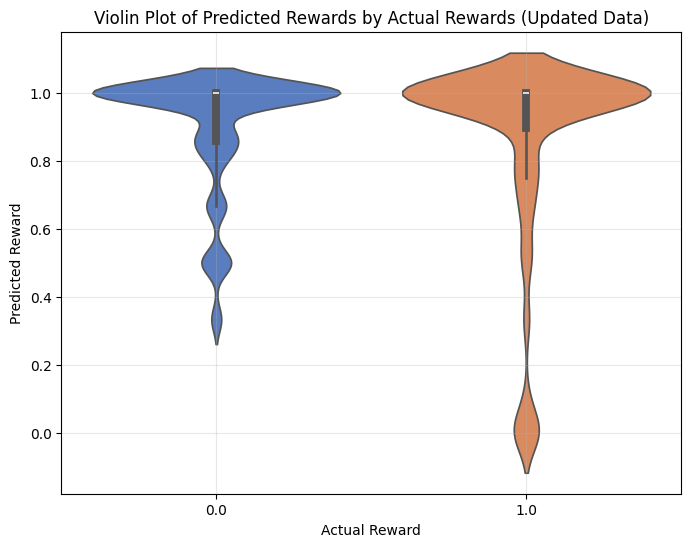

In [ ]:
# −0.373 negative correlation
import matplotlib.pyplot as plt
import seaborn as sns
# New dataset: predicted and actual rewards
# predicted_rewards_new = np.array([
#     1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 0.0, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0,
#     1.0, 1.0, 0.9230769230769231, 1.0, 1.0, 1.0, 1.0, 0.9, 0.8888888888888888,
#     0.5555555555555556, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0
# ])
# actual_rewards_new = np.array([
#     1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0,
#     0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0
# ])
predicted_rewards = np.array(pred_rewards)
actual_rewards = np.array(truth_rewards)

# Prepare updated data for violin plot
data_new = {
    'Actual Reward': actual_rewards,
    'Predicted Reward': predicted_rewards
}

# Create violin plot for the new dataset
plt.figure(figsize=(8, 6))
sns.violinplot(x=data_new['Actual Reward'], y=data_new['Predicted Reward'], palette='muted', inner='box', bw=0.2)

# Plot formatting
plt.title("Violin Plot of Predicted Rewards by Actual Rewards (Updated Data)")
plt.xlabel("Actual Reward")
plt.ylabel("Predicted Reward")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
#@title 2) check if relative score aligned ?

from xlm.posttrain.data.score.relative_scorer import POLICY_MODEL, ScoreType
from xlm.reward_client import RelativeRewardClient

async def process_prod_data(
    input_path,
    output_path,
    sampling_client=None,
    semaphore=None,
    pbar=None,
    scorer_client: RelativeRewardClient = None,
):
    """
    for prod  data: we get conversation and the model reponse back then?
    then we are rating the this model responses according to target and ref model
    here we did not rerank them yet, reranking is a cheaper post-processing that would be done later
    """
    output_path = output_path + "_org" + str(scorer_client.num_samples)
    df1 = utils.read_df(glob.glob(input_path)).iloc[:10]

    row_pbar = tqdm(total=len(df1), desc=f"Processing {input_path}", leave=False)

    async def process_row(example):
        conversation = example["conversation"][:-2]
        await scorer_client._generate(
            messages=conversation, example=example
        )  # return scores but also update example
        row_pbar.update(1)
        return example

    # Process in batches
    batch_size = 1  # len(df1) #  1000  # Adjust this based on your system's capacity
    mapped_data = []
    for start in range(0, len(df1), batch_size):
        batch = df1.iloc[start : start + batch_size]
        batch_results = await asyncio.gather(
            *(process_row(example) for _, example in batch.iterrows())
        )
        mapped_data.extend(batch_results)

    df2 = pd.DataFrame(mapped_data)

    utils.df_to_parquet(df2, output_path)
    print(output_path, len(df2))
    return df2


POLICY_MODEL = "plan17-1000-r4.jhuang.svc.max.x.ai"
DEFAULT_REALTIVE_REWARD_CLIENT = RelativeRewardClient(address=POLICY_MODEL, num_samples=1)
DEFAULT_REALTIVE_REWARD_CLIENT.max_parallel = 256

input_folder = "/data/yuchen/prod_data/eval_user_dislike_responses_09_01.parquet"
output_path = "/data/yuchen/prod_data/eval_user_dislike_responses_09_01_relative_rewards"
await process_prod_data(input_folder, output_path, scorer_client=DEFAULT_REALTIVE_REWARD_CLIENT)

[2024-11-20 21:19:44,589 E] [colabbox-0:1940436] sampling_client:1011: bedrock setup failed: The config profile (key0) could not be found


NameError: name 'utils' is not defined

In [ ]:
#@title show distribution of ratings
import matplotlib.pyplot as plt
import numpy as np

def plot_rating_distribution(ratings):
    # Count the occurrences of each rating
    unique_ratings, counts = np.unique(ratings, return_counts=True)

    # Create a bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size as per your need

    # Plotting
    plt.bar(unique_ratings, counts, align='center', alpha=0.8)

    # Customizing the plot
    plt.title('Distribution of Ratings', fontsize=16)
    plt.xlabel('Rating', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(unique_ratings)  # Set ticks for each unique rating

    # Add count labels on top of each bar
    for i, v in enumerate(counts):
        plt.text(unique_ratings[i], v, str(v), ha='center', va='bottom')

    # Show the plot
    plt.tight_layout()
    plt.show()
rating_data = [r for r in rating_data if r is not None]
plot_rating_distribution(rating_data)

In [ ]:
# display_conversation(rating_bad_example[1]['conversation'])

## Review Actual User Like/Dislike Data


In [ ]:
#@title fetch actual user feedback data
df_feedback = pl.read_parquet("/data/zihang/grok_x_trace/latest/2024-10-10/feedback_only.parquet").to_pandas()

In [ ]:
df_feedback

,chatId,userId,sorted_date,sorted_chatItemId,sorted_sender,sorted_generatedImageUrls,sorted_modelVersion,sorted_message,sorted_feedback
0,1853428889210524078,3328228605,"[1730726863, 1730726863]","[1853428890485538816, 1853428918411214849]","[USER, AGENT]","[[], []]","[grok-2-latest, grok-2-latest]","[Can you count the Total number of Hydrogen, C...","[None, LIKE]"
1,1845897135763419534,1706781915422797824,"[1728931188, 1728931188, 1728933179, 172893317...","[1845897136891670529, 1845897308988137472, 184...","[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[[], [], [], [], [], [], [], []]","[grok-2-latest, grok-2-latest, grok-2-latest, ...",[We discussed previously some instruction on l...,"[None, None, None, LIKE, None, LIKE, None, LIKE]"
2,1854473836340678923,1220480120064028672,"[1730975997, 1730975997]","[1854473837271728146, 1854473858931159062]","[USER, AGENT]","[[], []]","[grok-2-latest, grok-2-latest]",[How much did Biden gave to Ukraine yesterday?...,"[None, DISLIKE]"
3,1848101445922701409,218366025,"[1729456728, 1729456728, 1729456799, 172945679...","[1848101447490994176, 1848101583524868096, 184...","[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[[], [], [], [], [], [], [], [], [], [], [], [...","[grok-2-latest, grok-2-latest, grok-2-latest, ...","[What is ULA (space company?), ULA, or United ...","[None, None, None, LIKE, None, DISLIKE, None, ..."
4,1847696504234135666,36644191,"[1729360207, 1729360207]","[1847696610194837506, 1847696744450314246]","[USER, AGENT]","[[], []]","[grok-2-latest, grok-2-latest]","[What can you tell me about PS Stubbs, England...","[None, LIKE]"
...,...,...,...,...,...,...,...,...,...
60424,1858538236798206246,1743759260649963520,"[1731945030, 1731945030, 1731945049, 173194504...","[1858538238794698752, 1858538238794698753, 185...","[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[[], [], [], [], [], [], [], [], [], []]","[grok-2-latest, grok-2-latest, grok-2-latest, ...","[Tell me about byte the AI dog , Byte the AI d...","[None, None, None, None, None, LIKE, None, Non..."
60425,1858333681854632059,1830907727666651141,"[1731896261, 1731896261]","[1858333683574325248, 1858333683574325249]","[USER, AGENT]","[[], []]","[grok-2-latest, grok-2-latest]","[Berätta om dagens huvudnyheter, Ah, dagens hu...","[None, LIKE]"
60426,1854750633125200318,1592426453865758721,"[1731041987, 1731041987, 1731042070, 173104207...","[1854750635364921344, 1854750641375371264, 185...","[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[[], [], [], [], [], [], [], [], [], [], [], [...","[grok-2-latest, grok-2-latest, grok-2-latest, ...",[A quick poem about TBJ a Thai called June hav...,"[None, LIKE, None, None, None, None, None, Non..."
60427,1853932228885271031,53959529,"[1730846871, 1730846871]","[1853932232072744965, 1853932266432372747]","[USER, AGENT]","[[], []]","[grok-2-latest, grok-2-latest]",[Does the goddess Ishtar have an associated co...,"[None, LIKE]"


In [ ]:
# Function to check if 'DISLIKE' is in the list or if the list is None
def contains_dislike(feedbacks):
    if 'DISLIKE' in feedbacks:  # Check for None or empty list
        return True
    return False
# Apply the function to create a new column
df_feedback_neg = df_feedback[df_feedback['sorted_feedback'].apply(contains_dislike)]
df_feedback_neg

,chatId,userId,sorted_date,sorted_chatItemId,sorted_sender,sorted_generatedImageUrls,sorted_modelVersion,sorted_message,sorted_feedback
2,1854473836340678923,1220480120064028672,"[1730975997, 1730975997]","[1854473837271728146, 1854473858931159062]","[USER, AGENT]","[[], []]","[grok-2-latest, grok-2-latest]",[How much did Biden gave to Ukraine yesterday?...,"[None, DISLIKE]"
3,1848101445922701409,218366025,"[1729456728, 1729456728, 1729456799, 172945679...","[1848101447490994176, 1848101583524868096, 184...","[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[[], [], [], [], [], [], [], [], [], [], [], [...","[grok-2-latest, grok-2-latest, grok-2-latest, ...","[What is ULA (space company?), ULA, or United ...","[None, None, None, LIKE, None, DISLIKE, None, ..."
7,1846676439288136035,1442485796,"[1729117055, 1729117055, 1729117190, 172911719...","[1846676871271911424, 1846676893350735872, 184...","[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[[], [], [], [], [], [], [], []]","[grok-2-latest, grok-2-latest, grok-2-latest, ...","[Welche Zahl ist größer: 2,9 2,11, Die Zahl 2,...","[None, DISLIKE, None, DISLIKE, None, LIKE, Non..."
31,1846744414493811012,1816307727259357184,"[1729133201, 1729133201, 1729133299, 172913329...","[1846744530894118912, 1846744615451348992, 184...","[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[[], [], [], [], [], [], [], [], [], [], [], [...","[grok-2-latest, grok-2-latest, grok-2-latest, ...","[where are you getting your sources?, My sourc...","[None, None, None, None, None, None, None, Non..."
36,1853468227533262924,3328228605,"[1730736242, 1730736242]","[1853468230305615872, 1853468254074732544]","[USER, AGENT]","[[], []]","[grok-2-latest, grok-2-latest]",[Can you name 3 famous shows by Cem Yılmaz? I ...,"[None, DISLIKE]"
...,...,...,...,...,...,...,...,...,...
60396,1847998992719790107,1779743384363495424,"[1729432279, 1729432279, 1729432368, 172943236...","[1847998996783992832, 1847999038223687680, 184...","[USER, AGENT, USER, AGENT, USER, AGENT]","[[], [], [], [], [], []]","[grok-2-latest, grok-2-latest, grok-2-latest, ...",[This man is claiming that Cuba’s blackouts ar...,"[None, None, None, None, None, DISLIKE]"
60409,1854464457163894868,1220480120064028672,"[1730973760, 1730973760]","[1854464458736689155, 1854464479037120525]","[USER, AGENT]","[[], []]","[grok-2-latest, grok-2-latest]",[Who is the candidate in fifth place across al...,"[None, DISLIKE]"
60414,1857121829745221851,1822795738901819392,"[1731607325, 1731607325, 1731607647, 173160764...","[1857121830336667648, 1857121830336667649, 185...","[USER, AGENT, USER, AGENT, USER, AGENT, USER, ...","[[], [], [], [], [], [], [], [], [], [], [], [...","[grok-2-latest, grok-2-latest, grok-2-latest, ...",[for MD5 hash -\nmd5($api_url/$query/api_id/$a...,"[None, None, None, None, None, None, None, Non..."
60416,1851399978486555086,1079375752779444224,"[1730243128, 1730243128]","[1851399979224686592, 1851399986246008834]","[USER, AGENT]","[[], []]","[grok-2-latest, grok-2-latest]","[Who wrote the arrival of rain , ""The Arrival ...","[None, DISLIKE]"


In [ ]:
msgs_till_last_dislike = []
for _ , r in df_feedback_neg.iterrows():
  for i, f in enumerate(r['sorted_feedback']):
    if f == 'DISLIKE':
      msgs_till_last_dislike.append({"messages": r['sorted_message'][:i+1].tolist(), "feedback": r['sorted_feedback'][:i+1].tolist()})
      break
i = 0

In [ ]:
msgs_rating = msgs_till_last_dislike[i]
display_conversation(msgs_rating["messages"], ratings=msgs_rating["feedback"])
i+=1

In [ ]:
included=[7056, 1111, 1208, 1914, 1253, 5280, 2095, 2848, 449, 4528, 6623, 5861, 390, 3460, 7330, 6571, 177, 632, 4585, 4924, 5295, 485, 6176, 2943, 5752, 2194, 798, 5127, 8243, 2299, 4394, 4089, 6154, 3552, 2594, 372, 7215, 7085, 4867, 503, 2073, 2677, 5707, 7297, 6536, 3410]
excluded=[746, 5208, 5091, 6896, 6419, 1379, 3984, 2635, 2443, 7615, 4466, 602, 6266, 3248, 766, 5490, 3987, 80, 123, 7818, 6729, 2081, 5570, 4803, 1001, 476, 7893, 7785, 3441, 7904, 673, 7287, 6185, 2792, 7515, 2458, 2033, 4613, 1535, 7101, 1699, 767, 1515, 3053, 5283, 1784, 3872, 124, 7790, 4704, 4654, 3402, 4742, 756, 2662, 6451, 2001, 44, 4801, 4290, 1971, 2818, 1450, 4970, 6142, 2546, 7604, 5911, 2052, 6941, 62, 7437, 631, 810, 1065, 5782, 1227, 7700, 811, 7851, 5600, 72, 536, 2927, 354, 7513, 6423, 5353, 1799, 6343, 3509, 2476, 5781, 7779, 6296, 4575, 1156, 2099, 5562, 6681, 6883, 2538, 4272, 4523, 8172, 1397, 1414, 3615, 4247, 3370, 1125, 4286, 3343, 7539, 797, 6324, 3579, 1990, 5853, 5082, 6446, 3623, 1143, 5428, 6127, 8291, 6823, 2853, 3540, 7151, 195, 7420, 8019, 227, 6897, 7453, 4096, 3720, 5920, 2042, 7969, 4758, 7352, 915, 506, 3740, 4078, 5500, 3195, 1817, 8137, 2632, 8076, 443]

In [ ]:
output = "/data/yuchen/prod_data/grok_x_trace/"
all_user_dislike_since1020_df = utils.read_df(output + "/user_dislike_since2410.parquet")
# all_model_applogize_since1020_df = tils.read_df(output + "/model_applogize_since2410.parquet")

def is_query_of_none(entry):
    entry = entry.tolist()
    if isinstance(entry, list):
        return all(el is None for el in entry)
    return False

# Filter rows where `queries` is NOT a list of None
df = all_user_dislike_since1020_df #  pd.concat([all_user_dislike_since1020_df, all_model_applogize_since1020_df])
filtered_df = df[df['queries'].apply(is_query_of_none)]

reading paths: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]


In [ ]:
sample_df = filtered_df.sample(n=1000, random_state=42)

In [ ]:
included=[7056, 1111, 1208, 1914, 1253, 5280, 2095, 2848, 449, 4528, 6623, 5861, 390, 3460, 7330, 6571, 177, 632, 4585, 4924, 5295, 485, 6176, 2943, 5752, 2194, 798, 5127, 8243, 2299, 4394, 4089, 6154, 3552, 2594, 372, 7215, 7085, 4867, 503, 2073, 2677, 5707, 7297, 6536, 3410]
excluded=[746, 5208, 5091, 6896, 6419, 1379, 3984, 2635, 2443, 7615, 4466, 602, 6266, 3248, 766, 5490, 3987, 80, 123, 7818, 6729, 2081, 5570, 4803, 1001, 476, 7893, 7785, 3441, 7904, 673, 7287, 6185, 2792, 7515, 2458, 2033, 4613, 1535, 7101, 1699, 767, 1515, 3053, 5283, 1784, 3872, 124, 7790, 4704, 4654, 3402, 4742, 756, 2662, 6451, 2001, 44, 4801, 4290, 1971, 2818, 1450, 4970, 6142, 2546, 7604, 5911, 2052, 6941, 62, 7437, 631, 810, 1065, 5782, 1227, 7700, 811, 7851, 5600, 72, 536, 2927, 354, 7513, 6423, 5353, 1799, 6343, 3509, 2476, 5781, 7779, 6296, 4575, 1156, 2099, 5562, 6681, 6883, 2538, 4272, 4523, 8172, 1397, 1414, 3615, 4247, 3370, 1125, 4286, 3343, 7539, 797, 6324, 3579, 1990, 5853, 5082, 6446, 3623, 1143, 5428, 6127, 8291, 6823, 2853, 3540, 7151, 195, 7420, 8019, 227, 6897, 7453, 4096, 3720, 5920, 2042, 7969, 4758, 7352, 915, 506, 3740, 4078, 5500, 3195, 1817, 8137, 2632, 8076, 443, 3173, 7036, 5137, 5864, 4219, 2846, 1029, 4416, 4348, 3708, 4055, 6388, 2522, 3954, 460, 1323, 6510, 790, 4773, 7993, 3917, 512, 4176, 250, 5948, 4025, 7383, 2040, 1432, 2373, 1639, 1769, 1130, 5365, 4407, 110, 3403, 7888, 1129, 4104, 7947, 6254, 6014, 6666, 3636, 8269, 1264, 2426, 7734, 2117, 2508, 5029, 720, 3672, 4160, 1886, 7867, 635, 1812, 7259, 2791]

for idx, r in sample_df.iterrows():
  if idx in excluded or idx in included:
    continue
  display_conversation(r["org_conversation"])
  print("idx=", idx, "len=", len(included))
  print(f"include={included} \nexclude={excluded}" )
  user_input = input(f"Please enter your choice: \n").strip().lower()
  if user_input == 'n':
    excluded.append(idx)
  elif user_input == 'q':
    break
  else:
    included.append(idx)
  if len(included) == 100:
    print("100!!!")
    break
  clear_output()

NameError: name 'display_conversation' is not defined

In [ ]:
#  print(f"include={included} \nexclude={excluded}" )

include=[7056, 1111, 1208, 1914, 1253, 5280, 2095, 2848, 449, 4528, 6623, 5861, 390, 3460, 7330, 6571, 177, 632, 4585, 4924, 5295, 485, 6176, 2943, 5752, 2194, 798, 5127, 8243, 2299, 4394, 4089, 6154, 3552, 2594, 372, 7215, 7085, 4867, 503, 2073, 2677, 5707, 7297, 6536, 3410] 
exclude=[746, 5208, 5091, 6896, 6419, 1379, 3984, 2635, 2443, 7615, 4466, 602, 6266, 3248, 766, 5490, 3987, 80, 123, 7818, 6729, 2081, 5570, 4803, 1001, 476, 7893, 7785, 3441, 7904, 673, 7287, 6185, 2792, 7515, 2458, 2033, 4613, 1535, 7101, 1699, 767, 1515, 3053, 5283, 1784, 3872, 124, 7790, 4704, 4654, 3402, 4742, 756, 2662, 6451, 2001, 44, 4801, 4290, 1971, 2818, 1450, 4970, 6142, 2546, 7604, 5911, 2052, 6941, 62, 7437, 631, 810, 1065, 5782, 1227, 7700, 811, 7851, 5600, 72, 536, 2927, 354, 7513, 6423, 5353, 1799, 6343, 3509, 2476, 5781, 7779, 6296, 4575, 1156, 2099, 5562, 6681, 6883, 2538, 4272, 4523, 8172, 1397, 1414, 3615, 4247, 3370, 1125, 4286, 3343, 7539, 797, 6324, 3579, 1990, 5853, 5082, 6446, 3623, 1143

In [9]:
from IPython.display import display, HTML
import json

# Assuming 'data' is your dictionary containing the JSON data
rag_raw_data ="""
{
    "web_results": [
        {
            "doc_id": 0,
            "text": "The margin of victory in a U.S. presidential election, with the exception below, is the difference between the number of Electoral College votes garnered by the candidate with an absolute majority of electoral votes (since 1964, it has been 270 out of 538) and the number received by the second place candidate (currently in the range of 2 to 538, a margin of one vote is only possible with an odd total number of electors or a faithless elector).\nPrior to the ratification of the Twelfth Amendment in 1804, the winner of the presidential election was whoever received both a majority of electors to vote for them, and who received the most votes, because each elector cast two presidential votes.\nFor elections after the passage of the 12th Amendment, the runner-up will always have less than half of the electoral votes cast, so the absolute margin of victory will be the difference of the winner's electoral votes and half the electoral votes cast.\nThe table's \"runner-up\" column shows the number of electoral votes for the candidate receiving the second highest number of combined electoral votes, and thus was elected vice president, for each of these elections except for the 1800 election, which ended in a tie between two candidates – the presidential and vice presidential candidates of the same party.\nIn the following table, the election of 1824 is ranked closer than the election of 1800 because the 1800 election resulted in a tie between the same party's candidates for president and vice president (as presidential and vice presidential electoral votes were not distinguished), while the election of 1824 resulted in the contingent election in the House of Representatives selecting the candidate who had won the second highest number of electoral votes (out of the top three) since no candidate got a majority, 41 presidents have won a large total number of electoral votes, Franklin D. Roosevelt received the most total of electoral votes received by a candidate who was elected to the office of president due to him being the only one to serve more than 2 terms (1,876) and John Adams received the smallest (136).",
            "webpage": {
                "cached_page_url": null,
                "date_last_crawled": "2024-11-03T17:49:00Z",
                "date_published": null,
                "language": null,
                "parsed_text": "",
                "snippet": "The margin of victory in a U.S. presidential election, with the exception below, is the difference between the number of Electoral College votes garnered by the candidate with an absolute majority of electoral votes (since 1964, it has been 270 out of 538) and the number received by the second place candidate (currently in the range of 2 to 538 ...",
                "time_accessed": null,
                "title": "List of United States presidential elections by Electoral College margin - Wikipedia",
                "url": "https://en.wikipedia.org/wiki/List_of_United_States_presidential_elections_by_Electoral_College_margin"
            }
        },
        {
            "doc_id": 1,
            "text": "The merit of the electoral college system has been a matter of ongoing debate in the United States since its inception at the Constitutional Convention in 1787, becoming more controversial by the latter years of the 19th century, up to the present day.\nBecause the number of electors each state appoints is equal to the size of its congressional delegation, each state is entitled to at least three electors regardless of its population, and the apportionment of the statutorily fixed number of the rest is only roughly proportional.\n[ 19 ] [ 22 ] The results are sent to and counted by the Congress, where they are tabulated in the first week of January before a joint meeting of the Senate and the House of Representatives, presided over by the current vice president, as president of the Senate.\n[ 25 ] [ 26 ] [ 27 ] The additional three electors come from the Twenty-third Amendment, ratified in 1961, providing that the district established pursuant to Article I, Section 8, Clause 17 as the seat of the federal government (namely, Washington, D.C.) is entitled to the same number of electors as the least populous state.\nThey included the mode of election of the president, including final recommendations for the electors, a group of people apportioned among the states in the same numbers as their representatives in Congress (the formula for which had been resolved in lengthy debates resulting in the Connecticut Compromise and Three-Fifths Compromise), but chosen by each state \"in such manner as its Legislature may direct\".\n0) Choice of the president should reflect the \"sense of the people\" at a particular time, not the dictates of a faction in a \"pre-established body\" such as Congress or the State legislatures, and independent of the influence of \"foreign powers\".\n\"The function of the College of Electors in choosing the president can be likened to that in the Roman Catholic Church of the College of Cardinals selecting the Pope.",
            "webpage": {
                "cached_page_url": null,
                "date_last_crawled": "2024-11-03T17:23:00Z",
                "date_published": null,
                "language": null,
                "parsed_text": "",
                "snippet": "The number of electoral votes, out of 538, allocated to each state and the District of Columbia for presidential elections to be held in 2024 and 2028 based on the 2020 census.Every jurisdiction is entitled to at least 3. In the 2020 presidential election, held using 2010 census data, Joe Biden received 306 ( ) and Donald Trump 232 ( ) of the total 538 electoral votes.",
                "time_accessed": null,
                "title": "United States Electoral College - Wikipedia",
                "url": "https://en.wikipedia.org/wiki/United_States_Electoral_College"
            }
        },
        {
            "doc_id": 2,
            "text": "#  2024 Presidential Election Interactive Map\nIt will take 270 electoral votes to win the 2024 presidential election.\nClick states on this interactive map to create your own 2024 election forecast.\nCreate a specific match-up by clicking the party and/or names near the electoral vote counter.\nUse the buttons below the map to share your forecast or embed it into a web page.\nno 2024 election\nno 2024 election\nSafe Likely Leans Tilt Toss-up 3P\n1 2 3\nAs of Nov. 1, 2024 Details >>\n### State of Play: How 2022's Closest U.S. House Races are Looking in 2024\nNovember 2, 2024\nThe 2022 election in eleven districts was decided by a margin of less than 1%\n### 2024 General Election: Poll Closing Times\nOctober 27, 2024\nOctober 4, 2024\nOctober 1, 2024\nThe final special election before the November general election will fill a vacant safely Democratic seat in the Birmingham area.\nSeptember 18, 2024\nThe winner will complete the term of the late Democratic Rep. Donald Payne Jr.",
            "webpage": {
                "cached_page_url": null,
                "date_last_crawled": "2024-11-04T00:24:00Z",
                "date_published": null,
                "language": null,
                "parsed_text": "",
                "snippet": "Create your own forecast for the 2024 presidential election",
                "time_accessed": null,
                "title": "270toWin - 2024 Presidential Election Interactive Map",
                "url": "https://www.270towin.com/"
            }
        },
        {
            "doc_id": 3,
            "text": "# 2024 Presidential Election Polls\nThis page displays the current 270toWin Polling Average for each state.\nWhere that is not applicable, the most recent 2024 presidential election poll is used.\nThe average methodology is summarized below the table.\nTo view averages including 3rd party candidates, select the checkbox near the candidate names.\nSelect the link below each chart to see polling detail for that state.\n* The average includes the most recent poll from each source released within two weeks of the November 5 election.\nIf there are fewer than five, the window is expanded to 30 days or five polls from the date of the most recent poll, whichever comes first.\nIn the latter scenario, if there are multiple qualifying polls on the same calendar date as the oldest poll used, those will also be included.",
            "webpage": {
                "cached_page_url": null,
                "date_last_crawled": "2024-11-04T07:31:00Z",
                "date_published": null,
                "language": null,
                "parsed_text": "",
                "snippet": "View the results of 2024 election polls.",
                "time_accessed": null,
                "title": "2024 Presidential Election Polls: Harris vs. Trump - 270toWin",
                "url": "https://www.270towin.com/2024-presidential-election-polls/"
            }
        },
        {
            "doc_id": 4,
            "text": "WASHINGTON – As voters look to polls and political analysts for insight into who might win the presidency on Tuesday, a feud between two of the nation’s leading election prognosticators, Allan Lichtman and Nate Silver, will soon be put to the test.\nSilver, the statistician and pollster who founded FiveThirtyEight, wrote recently in the New York Times that the race is a virtual tie, but his “gut” tells him former President Donald Trump will likely prevail.\nLichtman devised the metrics he uses for his election forecast more than three decades ago with the help of an earthquake specialist and mathematician from Moscow named Vladimir Keilis-Borok.\nThe system, dubbed the \"13 Keys to the White House\" uses – you guessed it – thirteen true-or-false statements rooted in historical analysis about the state of the country, the parties and the candidates to determine who will win.\nLichtman has correctly predicted the outcome of nine out of the 10 most recent presidential elections, dating back to 1984.\nSilver gained national recognition in 2008 when his statistical model correctly forecast the outcome of the presidential election in 49 of the 50 states.\nHis model has since predicted the outcome of the presidential race in 2012 and 2020.\nThomas Miller, director of Northwestern University’s data science program, argued that both Silver and Lichtman’s strategies are “wrong in different ways.” Miller created an election forecasting system of his own combining 60 years of historical analysis and data from the betting market Predict It.\nHe argued that the absence of campaign events from his keys is one of the reasons they've been so successful.\n\"What some say is the weakness of the keys ... is the strength of the keys because it looks at fundamentals, not the ephemeral events of the campaign,\" Lichtman said.\n“I'm of the belief that campaigns do matter ... and that the candidate’s choices affect how voters think,” he said.\nWhere Lichtman's model looks to the established patterns of past elections to predict future presidential votes, Silver's provides insight into how views of the American electorate shifts over weeks and months.",
            "webpage": {
                "cached_page_url": null,
                "date_last_crawled": "2024-11-04T10:11:00Z",
                "date_published": "2024-11-03T10:11:00Z",
                "language": null,
                "parsed_text": "",
                "snippet": "Two of the biggest election prognosticators disagree over who will win the 2024 presidential race. Who's model is more accurate?",
                "time_accessed": null,
                "title": "Allan Lichtman vs. Nate Silver: Who will accurately predict the 2024 election?",
                "url": "https://www.usatoday.com/story/news/politics/elections/2024/11/03/allan-lichtman-nate-silver-election/75993624007/"
            }
        },
        {
            "doc_id": 5,
            "text": "#### Make your picks on the 2024 Interactive Electoral Map ABC News Chief Washington Correspondent Jonathan Karl explains how to make your predictions on the 2024 presidential race.\nA new poll from The New York Times/Siena College published today finds Vice President Kamala Harris and former President Donald Trump tied at 48 percent each in the national popular vote, confirming a trend toward Trump that 538 identified last week.\nThis and a few other new polls pushed Harris’s margin in our national average down from +1.7 to +1.5, less than the margin our model thinks is required for Harris to win the majority of Electoral College votes this year.\nCurrently, our model gives Trump a XXX out of 100 chance of winning the election, and gives Harris a XXX out of 100 chance.\nStill, the closeness of the race bears repeating what has become something of a mantra here at 538 recently: A close race in the polls does not necessarily mean the outcome will be close.\nMaine and Nebraska’s congressional districts are shown separately because those states split their Electoral College votes, allotting two to the statewide winner and one to the winner of each district.\nThe Voter Power Index (VPI) is a relative measure of how likely an individual voter in that state is to determine the outcome of the election.\nThe Voter Power Index (VPI) is a relative measure of how likely an individual voter in that state is to determine the outcome of the election.\nOur forecast is based on a combination of the polls and various economic and political variables we call the “fundamentals.” This chart shows how we get from the polls today to a forecast for Election Day.\nThe national polling average adjusted for results of state polls and the effects of party conventions.\nOur final forecast of the popular vote, based on a weighted average of the polls and fundamentals using the weights above.\n| Harris wins the popular vote but loses the Electoral College | 19 out of 100 |.\n| Trump wins the popular vote but loses the Electoral College | <1 out of 100 |.",
            "webpage": {
                "cached_page_url": null,
                "date_last_crawled": "2024-11-04T00:03:00Z",
                "date_published": "2024-11-03T00:00:00Z",
                "language": null,
                "parsed_text": "",
                "snippet": "538’s 2024 presidential election forecast model showing Democrat Kamala Harris’s and Republican Donald Trump’s chances of winning.",
                "time_accessed": null,
                "title": "Who Is Favored To Win The 2024 Presidential Election?",
                "url": "https://projects.fivethirtyeight.com/2024-election-forecast/"
            }
        },
        {
            "doc_id": 6,
            "text": "Tens of millions of voters in the United States are heading to the polls next week for the 2024 US presidential election.\nThe vote, held on 5 November, has gripped much of the world’s attention in recent months and could have a significant impact on the global economy.\nThe vote follows a lengthy primary process in which the two major political parties—the Democratic Party and the Republican Party—choose a candidate through state caucuses and primary votes.\nThe date of the election stems from a rule that the US Congress enacted in 1845 that mandated that US states appoint presidential electors every four years on “the Tuesday next after the first Monday in the month of November.” At the time, the US was a largely agrarian country so the early-November date allowed the handful of Americans who could vote at the time to access the polls after the autumn harvest and before the onset of winter.\nLocal residents line up to enter a polling site on the first day of early in-person voting in a region still severely impacted by the storm, in Asheville, North Carolina, U.S. October 17, 2024.\nIn this system, each of the 50 US states is allocated a number of electoral votes based on their representation in the US Congress.\nIn most states, the candidate who receives the majority of the popular vote wins all of the state’s electoral votes.\nThe Electoral College, which was established in the US Constitution, has been the subject of much debate given that the process can lead to candidates losing the popular vote but winning the electoral vote.\nThe turnout marked 65.9% of the voting age population and a significant increase from the 59.2% seen in 2016.\nThe US presidential vote comes in a historic year for elections, with more than 2 billion people in 50 countries heading to the polls in 2024.\nThe vote also comes as experts are increasingly sounding the alarm on political and societal polarization in the US and around the world.\nThe views expressed in this article are those of the author alone and not the World Economic Forum.",
            "webpage": {
                "cached_page_url": null,
                "date_last_crawled": "2024-11-04T06:49:00Z",
                "date_published": "2024-10-31T00:00:00Z",
                "language": null,
                "parsed_text": "",
                "snippet": "Tens of millions of voters in the United States are heading to the polls for the 2024 US presidential election. Here&#39;s how the election works. ",
                "time_accessed": null,
                "title": "Americans are going to the polls. Here’s how the US election works",
                "url": "https://www.weforum.org/stories/2024/10/united-states-polls-vote-usa-president-election-electoral-college/"
            }
        },
        {
            "doc_id": 7,
            "text": "Presidential Election Battleground States and Early Voting 2024 Results\nIE 11 is not supported.\nNBC News' Decision Desk characterizes the competitiveness of many of the races to be held in November.\nSeveral factors are considered in determining the ratings, including historical electoral results, election polling, analysis of voter registration data and early voting (when applicable), political advertising data, as well as qualitative assessments of the specific candidates.\n2020 Results\nElectoral College Results, 1992-2020\n2020 Biden\n306\n232\n2016 H. Clinton\n227\n304\n2012 Obama\n332\n206\n2008 Obama\n365\n173\n2004 Kerry\n251\n286\n2000 Gore\n266\n271\n1996 B. Clinton\n379\n159\n1992 B. Clinton\n370\n168\nG.H.W. Bush\n### Vote Margin by State in the 2020 Presidential Election\n| 3 EVs | +86.7 D |.\n| Biden | 92.1% |.\n| Trump | 5.4% |.\n| 3 EVs | +35.1 D |.\n| Biden | 66.1% |.\n| Trump | 30.7% |.\n| 10 EVs | +33.2 D |.\n| Biden | 65.4% |.\n| Trump | 32.2% |.\n| 11 EVs | +33.2 D |.\n| Biden | 65.6% |.\n| Trump | 32.1% |.\nThe expected vote is the total number of votes that are expected in a given race once all votes are counted.\nThis number is an estimate and is based on several different factors, including information on the number of votes cast early as well as information provided to our vote reporters on Election Day from county election officials.",
            "webpage": {
                "cached_page_url": null,
                "date_last_crawled": "2024-11-03T15:03:00Z",
                "date_published": "2024-11-03T00:00:00Z",
                "language": null,
                "parsed_text": "",
                "snippet": "View Presidential Election early voting results by state map, see the battleground states, and key races to watch from NBC News.",
                "time_accessed": null,
                "title": "Presidential Election Preview 2024",
                "url": "https://www.nbcnews.com/politics/2024-elections/president-electoral-college-battleground-states"
            }
        }
    ]
}
"""

# Function to escape HTML special characters
def escape_html(text):
    return text.replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;').replace('"', '&quot;').replace("'", '&#39;')

# Start of HTML string
html_string = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>2024 Election Search Results</title>
    <style>
        .result {
            margin-bottom: 20px;
            border-bottom: 1px solid #ddd;
            padding-bottom: 10px;
        }
        .title {
            font-size: 18px;
            color: #1a0dab;
            text-decoration: none;
        }
        .url {
            color: #006621;
            font-size: 14px;
        }
        .snippet {
            color: #545454;
        }
    </style>
</head>
<body>
    <h1>2024 Election Search Results</h1>
    <div id="results">
"""

data = json.loads(rag_raw_data)

# Loop through each result in web_results
for result in data['web_results']:
    html_string += f"""
        <div class="result">
            <a class="title" href="{escape_html(result['webpage']['url'])}">{escape_html(result['webpage']['title'])}</a>
            <span class="url">{escape_html(result['webpage']['url'])}</span>
            <p class="snippet">{escape_html(result['webpage']['snippet'])}</p>
        </div>
    """

# Close the HTML
html_string += """
    </div>
</body>
</html>
"""


In [12]:
g

JSONDecodeError: Invalid control character at: line 6 column 469 (char 528)